In [1]:
import requests
import json
import random
import time

# Base URL of the FastAPI server
BASE_URL = "http://localhost:8000"

# Optional: user_id for personalized /locations/recommended
# Get this from /auth/login if you want to test recommendations
USER_ID = None  # e.g. "6e0e5c7e-1234-4567-890a-bcdef1234567"

HEADERS = {"X-User-ID": USER_ID} if USER_ID else {}

print("BASE_URL =", BASE_URL)
print("USER_ID =", USER_ID)


BASE_URL = http://localhost:8000
USER_ID = None


## 🗑️ Delete All Existing Locations (Optional)

⚠️ **Warning:** This will permanently delete all locations from the database. Run this cell only if you want to start fresh.

In [4]:
# Set to True to enable deletion
DELETE_ALL = True

if DELETE_ALL:
    # Fetch all existing locations
    url = f"{BASE_URL}/locations/"
    res = requests.get(url)
    
    if res.status_code == 200:
        all_locations = res.json()
        deleted_count = 0
        
        print(f"Found {len(all_locations)} locations. Deleting...")
        
        for location in all_locations:
            location_id = location.get("id")
            if location_id:
                delete_url = f"{BASE_URL}/locations/{location_id}"
                delete_res = requests.delete(delete_url)
                
                if delete_res.status_code == 200:
                    deleted_count += 1
                    print(f"✓ Deleted: {location.get('name', 'Unknown')} ({location_id})")
                else:
                    print(f"✗ Failed to delete: {location.get('name', 'Unknown')} - Status {delete_res.status_code}")
        
        print(f"\n✅ Deleted {deleted_count} out of {len(all_locations)} locations")
    else:
        print(f"Failed to fetch locations. Status: {res.status_code}")
else:
    print("⚠️ Deletion is disabled. Set DELETE_ALL = True to enable.")

Found 52 locations. Deleting...
✓ Deleted: Victoria Peak (de3763f6-41a4-4370-bb03-0baa7f921ecc)
✓ Deleted: Tsim Sha Tsui Promenade (70389361-b298-4a67-84cc-1a03953b41bc)
✓ Deleted: Mong Kok Night Market (727b8cf6-22ee-4df6-a0a1-416d38e75bb5)
✓ Deleted: Hong Kong Disneyland (db795eb0-f995-4faf-889b-0cb6e48fe50b)
✓ Deleted: Lion Rock (d535d0c4-8384-44f9-9e9f-4792b7c0c859)
✓ Deleted: Dragon's Back (05e2f8fe-9f79-48ea-bce7-3e1dd7b5b682)
✓ Deleted: Mount Parker (ac9dc280-da80-4202-837d-0e0508312680)
✓ Deleted: Lantau Peak (0912babd-ccd6-4f11-9771-8dcace4a0fcc)
✓ Deleted: Tai Mo Shan (bf4c15f3-6b24-4dc7-8e23-81e1c9e058eb)
✓ Deleted: Sharp Peak (e5f67c48-7eb9-4cd5-8468-21d2fb7f30c8)
✓ Deleted: Sunset Peak (3c2a07ac-adc7-4975-a91c-d6589e028fd3)
✓ Deleted: Needle Hill (6d6d1942-b6f3-476f-952d-77f82f7e15ba)
✓ Deleted: Ma On Shan (63b96e4e-f288-43e4-b26c-245168cad392)
✓ Deleted: High West (f02f8311-50e3-446c-8c69-1512d62df392)
✓ Deleted: Pat Sin Leng (0ad0c807-ce5b-41cb-b09d-95bff4472a7c)
✓ Delet

In [5]:
location_names = [
    "Victoria Peak", "Lion Rock", "Dragon's Back", "Mount Parker", "Lantau Peak",
    "Tai Mo Shan", "Sharp Peak", "Sunset Peak", "Needle Hill", "Ma On Shan",
    "High West", "Pat Sin Leng", "Jardine's Lookout", "The Twins", "Castle Peak",
    "Pineapple Mountain", "Shing Mun Reservoir", "Aberdeen Peak", "Clear Water Bay Peak",
    "Ap Lei Chau Trail", "Cape D’Aguilar", "Sai Wan Peak"
]

areas = ["Central", "Kowloon", "New Territories", "Lantau", "Hong Kong Island"]
price_levels = [1, 2, 3, 4]

bulk_created_ids = []

for name in location_names:
    payload = {
        "name": name,
        "description": f"A scenic location known as {name}.",
        "maps_url": "https://maps.example.com",
        "price_level": random.choice(price_levels),
        "area": random.choice(areas),
    }

    url = f"{BASE_URL}/locations/"
    try:
        res = requests.post(url, json=payload)
        print(f"Created {name} → Status {res.status_code}")
        data = res.json()
        loc_id = data.get("id")
        if loc_id:
            bulk_created_ids.append(loc_id)
    except Exception as e:
        print(f"Error creating {name}: {e}")

time.sleep(0.5)
print("\nTotal created:", len(bulk_created_ids))
bulk_created_ids[:5]


Created Victoria Peak → Status 200
Created Lion Rock → Status 200
Created Dragon's Back → Status 200
Created Mount Parker → Status 200
Created Lantau Peak → Status 200
Created Tai Mo Shan → Status 200
Created Sharp Peak → Status 200
Created Sunset Peak → Status 200
Created Needle Hill → Status 200
Created Ma On Shan → Status 200
Created High West → Status 200
Created Pat Sin Leng → Status 200
Created Jardine's Lookout → Status 200
Created The Twins → Status 200
Created Castle Peak → Status 200
Created Pineapple Mountain → Status 200
Created Shing Mun Reservoir → Status 200
Created Aberdeen Peak → Status 200
Created Clear Water Bay Peak → Status 200
Created Ap Lei Chau Trail → Status 200
Created Cape D’Aguilar → Status 200
Created Sai Wan Peak → Status 200
Created Shing Mun Reservoir → Status 200
Created Aberdeen Peak → Status 200
Created Clear Water Bay Peak → Status 200
Created Ap Lei Chau Trail → Status 200
Created Cape D’Aguilar → Status 200
Created Sai Wan Peak → Status 200

Total 

['fea0dceb-09ae-499e-9316-4800059c092c',
 '0ea5e630-4155-4dcd-a663-3aad2a3cce0a',
 '2321ef5c-0b04-4f4b-835d-03c568491afa',
 'ba22a1e1-e453-47ef-8314-e6386bf7bad7',
 '82de1eb1-9853-4700-81dc-e58e1289fa31']

In [6]:
url = f"{BASE_URL}/locations/"
res = requests.get(url)

print("Status:", res.status_code)
all_locations = res.json()
print("Total locations returned:", len(all_locations))
print(json.dumps(all_locations[:3], indent=2))  # show first 3


Status: 200
Total locations returned: 22
[
  {
    "name": "Victoria Peak",
    "description": "A scenic location known as Victoria Peak.",
    "maps_url": "https://maps.example.com",
    "price_level": 1,
    "area": "Hong Kong Island",
    "region": null,
    "summary": null,
    "duration": null,
    "opening_hours": null,
    "id": "fea0dceb-09ae-499e-9316-4800059c092c",
    "created_at": "2025-11-24T13:53:38.056597+08:00"
  },
  {
    "name": "Lion Rock",
    "description": "A scenic location known as Lion Rock.",
    "maps_url": "https://maps.example.com",
    "price_level": 2,
    "area": "New Territories",
    "region": null,
    "summary": null,
    "duration": null,
    "opening_hours": null,
    "id": "0ea5e630-4155-4dcd-a663-3aad2a3cce0a",
    "created_at": "2025-11-24T13:53:38.074758+08:00"
  },
  {
    "name": "Dragon's Back",
    "description": "A scenic location known as Dragon's Back.",
    "maps_url": "https://maps.example.com",
    "price_level": 2,
    "area": "Lant

Found 22 locations
Testing image retrieval for: Victoria Peak (fea0dceb-09ae-499e-9316-4800059c092c)
✓ Image retrieved successfully!


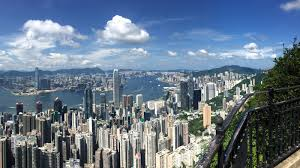

In [9]:
import requests
from IPython.display import Image, display
import io

BASE_URL = "http://127.0.0.1:8000"

# 1. Fetch all locations to pick one ID
loc_res = requests.get(f"{BASE_URL}/locations/")
all_locations = loc_res.json()

print(f"Found {len(all_locations)} locations")

# Pick first location
location = all_locations[0]
loc_id = location["id"]
name = location["name"]

print(f"Testing image retrieval for: {name} ({loc_id})")

# 2. Request the image using the new API
img_url = f"{BASE_URL}/locations/{loc_id}/image"
img_res = requests.get(img_url)

if img_res.status_code == 200:
    print("✓ Image retrieved successfully!")
else:
    print("✗ Failed to retrieve image:", img_res.status_code, img_res.text)

# 3. Display the image in the notebook
display(Image(data=img_res.content))


In [8]:
# Example: filter by area and price_level
url = f"{BASE_URL}/locations/?area=Central&price_level=2"
res = requests.get(url)

print("Status:", res.status_code)
filtered_locations = res.json()
print("Filtered locations count:", len(filtered_locations))
print(json.dumps(filtered_locations[:3], indent=2))


Status: 200
Filtered locations count: 1
[
  {
    "name": "Sharp Peak",
    "description": "A scenic location known as Sharp Peak.",
    "maps_url": "https://maps.example.com",
    "price_level": 2,
    "area": "Central",
    "region": null,
    "summary": null,
    "duration": null,
    "opening_hours": null,
    "id": "0a5720e7-e045-411e-af0f-411b880de6bc",
    "created_at": "2025-11-24T13:53:38.139493+08:00"
  }
]


In [5]:
if bulk_created_ids:
    test_location_id = bulk_created_ids[0]
    print("Using test_location_id from bulk_created_ids:", test_location_id)
elif all_locations:
    test_location_id = all_locations[0]["id"]
    print("No bulk_created_ids, using first from all_locations:", test_location_id)
else:
    test_location_id = None
    print("No locations available to test.")

test_location_id


Using test_location_id from bulk_created_ids: 7cf922ab-8e93-4d6e-b7dd-686a0c2f2e9d


'7cf922ab-8e93-4d6e-b7dd-686a0c2f2e9d'

In [6]:
if not test_location_id:
    raise RuntimeError("No test_location_id available. Run previous cells first.")

url = f"{BASE_URL}/locations/{test_location_id}"
res = requests.get(url)

print("Status:", res.status_code)
print(json.dumps(res.json(), indent=2))


Status: 200
{
  "location": {
    "name": "Victoria Peak",
    "description": "A scenic location known as Victoria Peak.",
    "maps_url": "https://maps.example.com",
    "price_level": 3,
    "area": "Central",
    "region": null,
    "summary": null,
    "duration": null,
    "opening_hours": null,
    "id": "7cf922ab-8e93-4d6e-b7dd-686a0c2f2e9d",
    "created_at": "2025-11-23T14:32:47.320248+08:00"
  },
  "images": [],
  "tags": []
}


In [7]:
update_payload = {
    "name": "Updated Test Location",
    "price_level": 3,
}

url = f"{BASE_URL}/locations/{test_location_id}"
res = requests.put(url, json=update_payload)

print("Status:", res.status_code)
print(json.dumps(res.json(), indent=2))


Status: 200
{
  "name": "Updated Test Location",
  "description": "A scenic location known as Victoria Peak.",
  "maps_url": "https://maps.example.com",
  "price_level": 3,
  "area": "Central",
  "region": null,
  "summary": null,
  "duration": null,
  "opening_hours": null,
  "id": "7cf922ab-8e93-4d6e-b7dd-686a0c2f2e9d",
  "created_at": "2025-11-23T14:32:47.320248+08:00"
}


In [8]:
import os

image_path = "test_image.jpg"  # change if needed

if os.path.exists(image_path):
    url = f"{BASE_URL}/locations/{test_location_id}/images"
    with open(image_path, "rb") as f:
        files = {"file": (os.path.basename(image_path), f, "image/jpeg")}
        res = requests.post(url, files=files)

    print("Status:", res.status_code)
    print(json.dumps(res.json(), indent=2))
else:
    print(f"Image file not found: {image_path}. Skipping image upload test.")


Image file not found: test_image.jpg. Skipping image upload test.


In [ ]:
tags_payload = {
    "tags": ["hiking", "scenic", "sunset"]
}

url = f"{BASE_URL}/locations/{test_location_id}/tags"
res = requests.post(url, json=tags_payload)

print("Status:", res.status_code)
tags_response = res.json()
print(json.dumps(tags_response, indent=2))

tag_ids = [t.get("id") for t in tags_response.get("added_tags", []) if t.get("id") is not None]
tag_ids


: 

In [ ]:
if tag_ids:
    tag_id = tag_ids[0]
    url = f"{BASE_URL}/locations/{test_location_id}/tags/{tag_id}"
    res = requests.delete(url)

    print("Status:", res.status_code)
    print(json.dumps(res.json(), indent=2))
else:
    print("No tag_ids available to delete.")


: 

In [ ]:
if not USER_ID:
    print("USER_ID is not set. Skipping /locations/recommended test.")
else:
    url = f"{BASE_URL}/locations/recommended?limit=10"
    res = requests.get(url, headers=HEADERS)
    print("Status:", res.status_code)
    print(json.dumps(res.json(), indent=2))


: 

In [ ]:
cleanup = False  # set to True if you want to delete the test location

if cleanup and test_location_id:
    url = f"{BASE_URL}/locations/{test_location_id}"
    res = requests.delete(url)
    print("Status:", res.status_code)
    print(json.dumps(res.json(), indent=2))
elif not cleanup:
    print("Cleanup is disabled. Set cleanup = True to delete the test location.")
else:
    print("No test_location_id to delete.")


: 